***Parameter Definitions***

In [13]:
nx, ny, nz              = 32, 32, 8                    # Spatial Dimension
m                       = 4                            # Number of Patterns
dd_factor               = 2                             # Detector Downsampling Factor

Load object

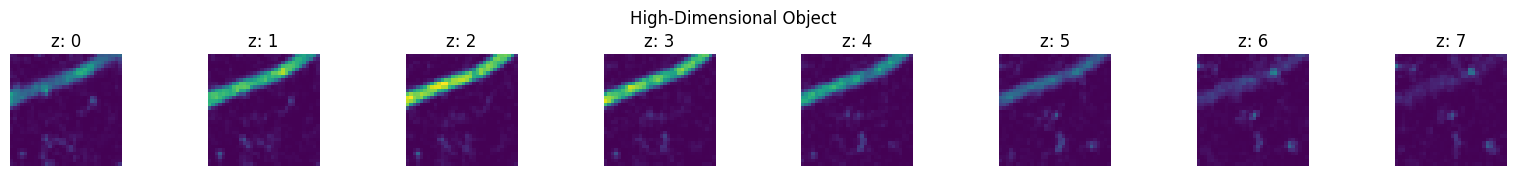

In [14]:
from libs.forward_lib.read_data import ReadData
from libs.forward_lib.simulate_data import MnistSimulator
import numpy as np

RD = ReadData(nx, ny, nz, up_factor=0.5)
RD.load_object("blood_cell")
RD.visualize_data(is_orginal=True)
X = RD.X.cpu().numpy().reshape(nx*ny*nz, 1)

# MS = MnistSimulator(nx, ny, nz, up_factor=(1/5,1,1))
# MS.update_data()
# X = MS.X.cpu().numpy().reshape(nx*ny*nz, 1)
# MS.visualize_object(vis_planes=True)

Linearized Model

In [15]:
from libs.forward_lib.linearized_process_D2NN import LinearizedModel

LM = LinearizedModel(nx, ny, nz, m, dd_factor, n_planes=1)
LM.init_models()
print(LM)

LM.find_transformation()

FM = LM.A.cpu().numpy()

Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 8.000um × 8.000um × 2.000um
Voxel Size 			: 0.25um × 0.25um × 0.25um
Original Shape 			: 32 × 32 × 8
D2NN Patterns 			: 4
# of Plane			: 1
Detector Pool size 		: 2×2
Computational Device 		: cpu




Pattern: 4/4	 Nz: 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]


In [16]:
y_clean = FM@X

def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB).reshape(m*(nx//dd_factor)*(ny//dd_factor), 1)

Run twist


Initial objective = 3625.37817142279, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Iteration = 2, objective = 850.6923114846445, nz = 7168, criterion = 76.535073825118
Iteration = 3, objective = 372.7354117080916, nz = 7168, criterion = 56.18446215205747
Iteration = 4, objective = 352.28337582014865, nz = 7168, criterion = 5.487011763711893
Iteration = 5, objective = 141.29498414065372, nz = 7168, criterion = 59.89166851495453
Iteration = 6, objective = 103.05125324264176, nz = 7168, criterion = 27.066587770689576
Iteration = 7, objective = 97.20097962633743, nz = 7168, criterion = 5.677052371725587
Iteration = 8, objective = 89.00797912913782, nz = 7168, criterion = 8.428927906586285
Iteration = 9, objective = 61.05698199182911, nz = 7168, criterion = 31.40279940156356
Iteration = 10, objective = 53.5400656177544, nz = 7168, criterion = 12.311313348374563
Iteration = 11, objectiv

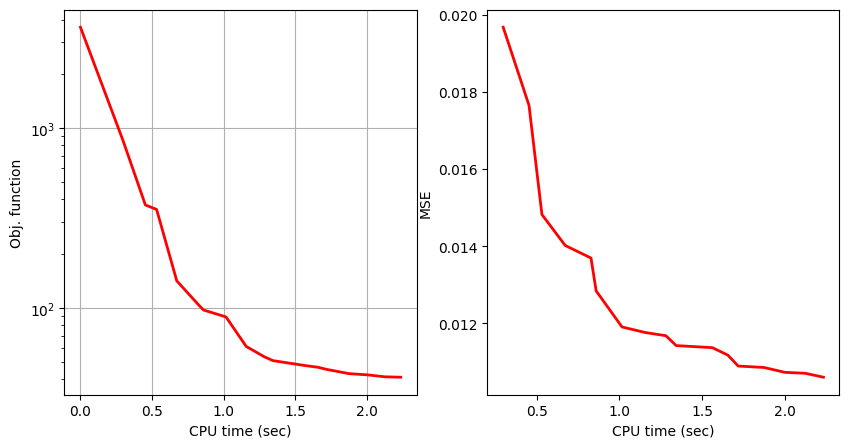

TwIST CPU time: 2.234375
MSE Loss: 1.0607e-02


f:\miniconda3\envs\FYP\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


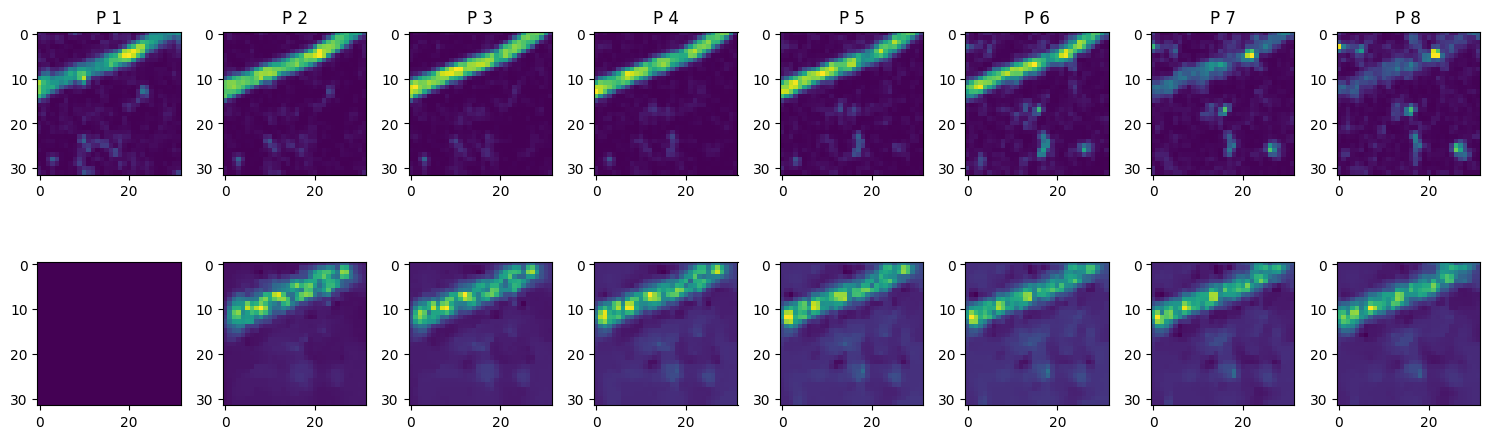

plane 1 | SSIM = 0.0000 | PSNR = -inf dB
plane 2 | SSIM = 0.5200 | PSNR = 15.1324 dB
plane 3 | SSIM = 0.5756 | PSNR = 13.8783 dB
plane 4 | SSIM = 0.6337 | PSNR = 15.1532 dB
plane 5 | SSIM = 0.6575 | PSNR = 19.0574 dB
plane 6 | SSIM = 0.6600 | PSNR = 22.5831 dB
plane 7 | SSIM = 0.5359 | PSNR = 18.3951 dB
plane 8 | SSIM = 0.4530 | PSNR = 16.7100 dB


In [18]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_noisy

tau = 0.01 # Regularization parameter
Psi = 'TV' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'TV' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-4 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-2 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)

utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))